# IDS Bayesian Interferometry

In [1]:
import pymc3 as pm
import numpy as np

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
def show_fft_image(img_fft, shift = True, save = False , name = 'my_name.png'):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs)
    
    if save:
        plt.savefig(name, format= 'png')
    
    plt.show()

## Creating artificial data

In [31]:
size = 1
MAX_VALUE = 255
MIN_VALUE = 0
IMAGE_SIZE_X = 50
IMAGE_SIZE_Y = 50
SIGMA = 5

#I = np.ceil((MAX_VALUE - MIN_VALUE) * np.random.rand(size) + MIN_VALUE)
#Cx = np.ceil((IMAGE_SIZE_X)/2 + SIGMA*np.random.randn(size)).astype('int')
#Cx = np.clip(Cx,0,IMAGE_SIZE_X)
#Cy = np.ceil((IMAGE_SIZE_Y)/2 +  SIGMA*np.random.randn(size)).astype('int')
#Cy = np.clip(Cy,0,IMAGE_SIZE_Y)

I = np.array([180])
Cx = np.array([25])
Cy = np.array([25])

minI = np.min(I)
argminI = np.argmin(I)
maxI = np.max(I)
argmaxI = np.argmax(I)

print('min I: %s at (%s,%s)\n' \
      'max I: %s at (%s,%s)\n' % (minI, Cx[argminI], Cy[argminI],
                                  maxI, Cx[argmaxI], Cy[argmaxI]))

min I: 180 at (25,25)
max I: 180 at (25,25)



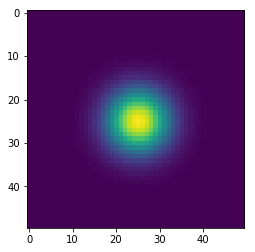

In [33]:
import matplotlib.pyplot as plt
from modelfunctions import *

Im_sinthc = sintheticImage(I,Cx,Cy, l=SIGMA, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y)
plt.imshow(Im_sinthc)
plt.savefig('img_sinthc.png', format='png')
plt.show()

img = Im_sinthc #rename variable

In [34]:
# Calculate the spectrum
img_fft, img_fftabs = spectrum(img)

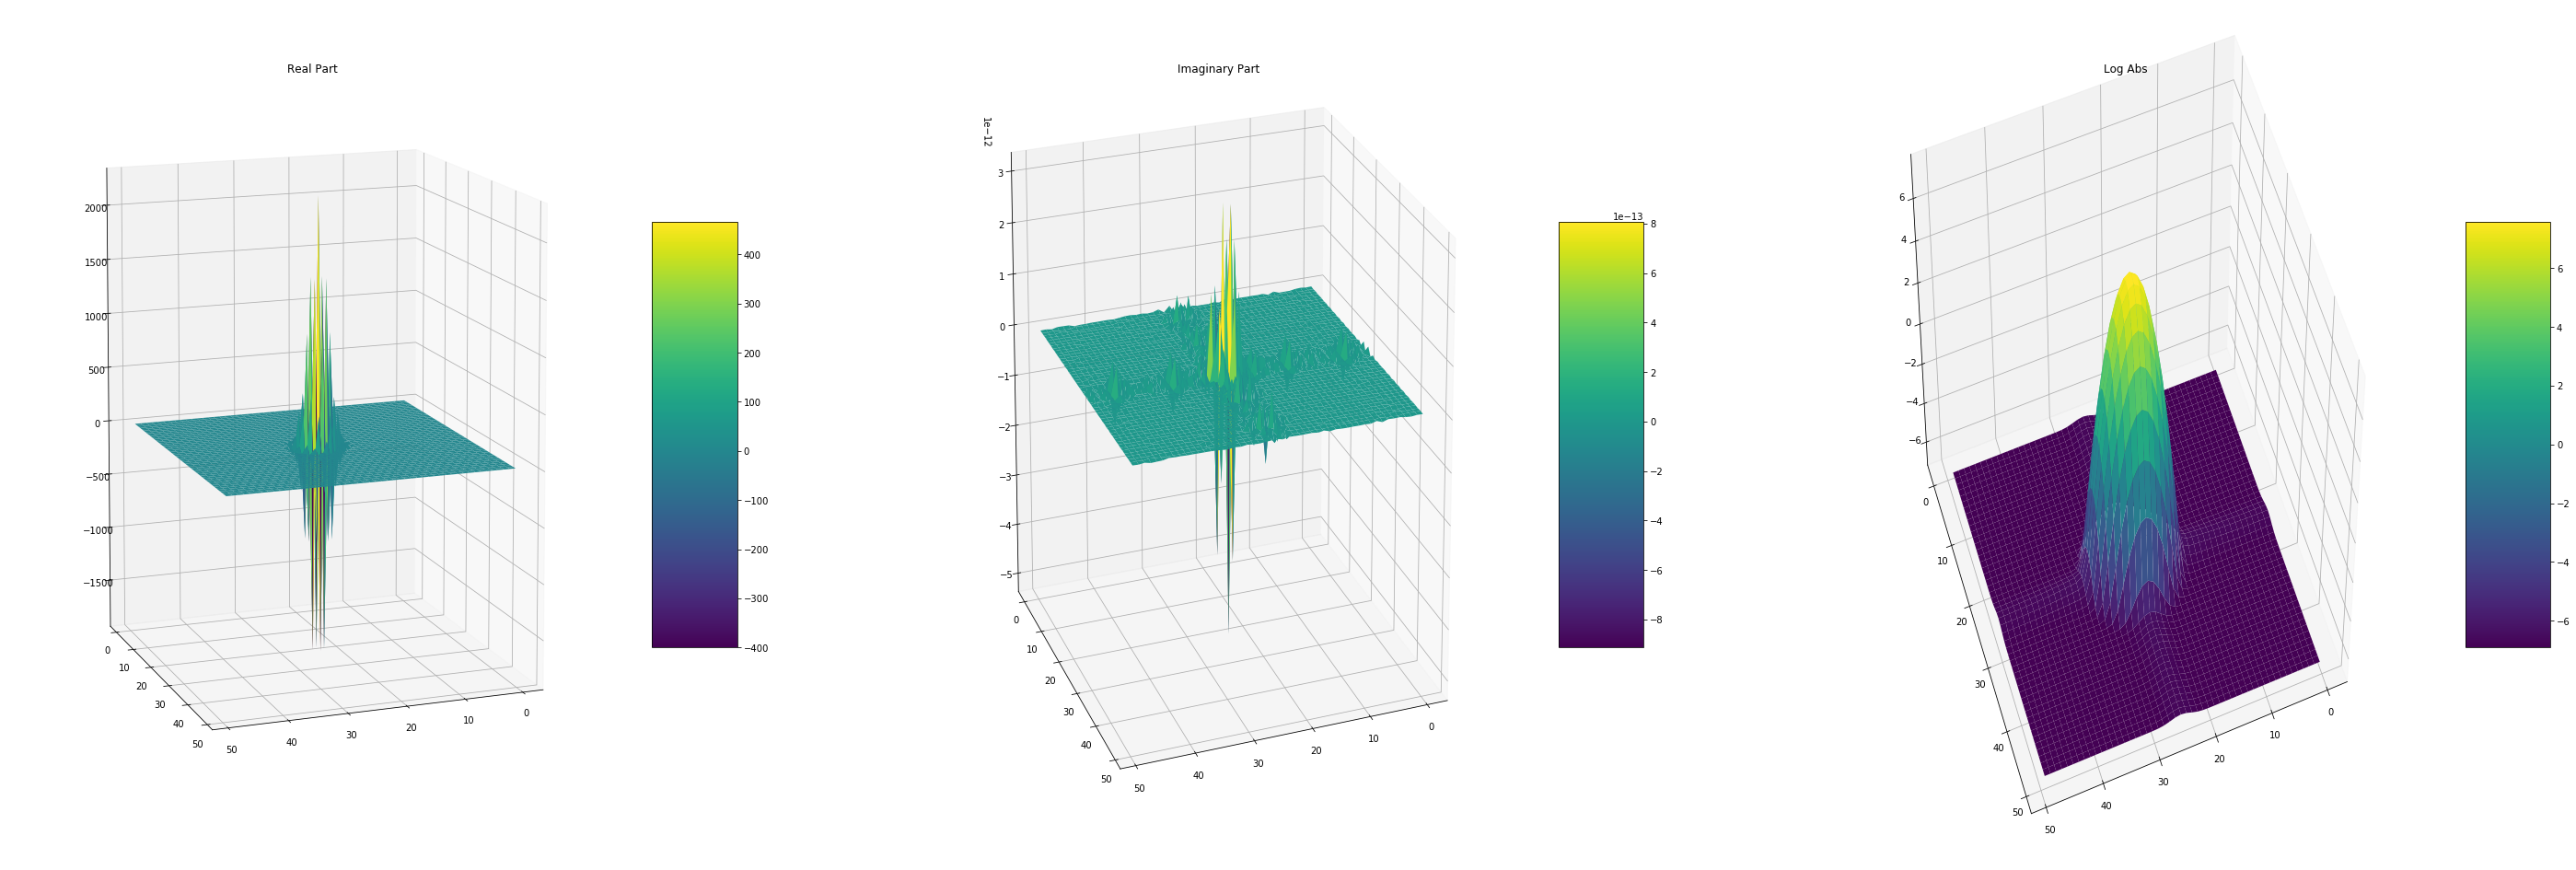

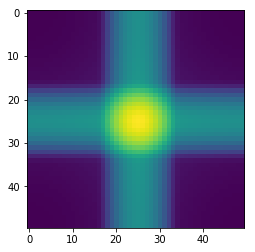

In [55]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# 3D plotting
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 3, 1, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(img_fft.real)


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Real Part")

ax.view_init(elev=10., azim = 70)

# 3D plotting
ax = fig.add_subplot(1, 3, 2, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(img_fft.imag)


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Imaginary Part")

ax.view_init(elev=20., azim = 70)

# 3D plotting
ax = fig.add_subplot(1, 3, 3, projection='3d')

UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = np.fft.fftshift(np.log(img_fftabs+0.001))


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Log Abs")

ax.view_init(elev=50., azim = 70)

fig.set_figheight(17)
fig.set_figwidth(50)

plt.savefig('img_sinthc_fourier.png', format='png')
plt.show(fig)

show_fft_image(np.log(img_fftabs+1e-12), save=True, name = 'Im_fft.png')

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

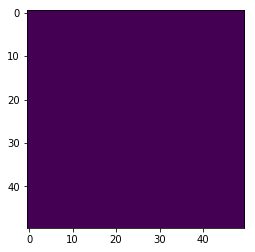

In [58]:
from masking import *

## Parameters
B_max = 1
antennas = 60
typeArray = 'ALL'
sigma = B_max/6.0

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

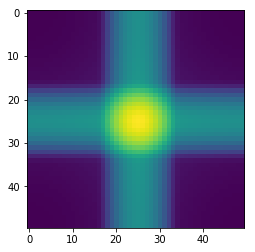

In [59]:
measurements,U,V = UVCreator(np.fft.fftshift(img_fft),mask)

measurements_abs = np.log(np.abs(measurements)+1e-12)
show_fft_image(measurements_abs, shift=False)

## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace
\end{array}\right]$$


$$
\phi_i(u,v) = 2 \pi \sigma^2 \exp \left(-2 \pi\left(j C_x^i u+jC_y^i v+\pi  \sigma^2\left(u^2+v^2\right)\right)\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 u-C_x^i \right),e^{-2 \pi^2 \sigma^2}\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 v-C_y^i\right),e^{-2 \pi^2 \sigma^2}\right)
$$


where:

$$
\vartheta_3 (q,z) = 1 + 2\sum_{n = 1}^{\infty} q^{n^2}\cos(2nz)
$$

In [133]:
import theano.tensor as tt

PI = np.pi
def Vobs_function(U,l,alpha,Cx,Cy, IMAGE_SIZE_X = 50, Tu = 1, Tv = 1, IMAGE_SIZE_Y = 50, shift = True):
#     print "U shape: %s, U type: %s\nl type: %s\nCx and Cy type: %s"%(U.shape, type(U), type(l), type(Cx))
#     U_tmp = U
#     C_tmp = tt.stack([Cx,Cy], axis = 1)
#     if shift:
#         U_tmp = U_tmp - np.array([IMAGE_SIZE_X, IMAGE_SIZE_Y])/2
#         C_tmp = C_tmp - np.array([IMAGE_SIZE_X, IMAGE_SIZE_Y])/2
    
    u = U[:,0] - IMAGE_SIZE_X/2  
    u_aux = u[:,np.newaxis]*Tu
    v = U[:,1] - IMAGE_SIZE_Y/2
    v_aux = v[:,np.newaxis]*Tv
    
    Cx_aux = Tu*(Cx - IMAGE_SIZE_X/2)
    Cy_aux = Tv*(Cy - IMAGE_SIZE_Y/2)
    
    A = tt.exp(-2.0*PI*PI*(u_aux * u_aux + v_aux * v_aux) *l*l)
#     A_aux = tt.extra_ops.repeat(A, numberOfBasis,axis=1)
#     print 'Atenuation:'
#     print A.eval()
#     print 'max: %s, min: %s' % ( np.max(A.eval()), np.min(A.eval() ))
    
#     print "Amplitude shape: %s, Amplitude type: %s" %(A_aux.eval().shape, type(A))
#     argument = 2.0 * PI * (np.outer(u,Cx) + np.outer(v,Cy))
    argument = -2.0*PI*(u[:,None]*Cx_aux[None,:] + v[:,None]*Cy_aux[None,:])
#     print "argument shape: %s, argument type: %s" %(argument.shape, type(argument))
    
    cosPart = tt.cos(argument)
    sinPart = tt.sin(argument)   
    
#     print "Cosine:"
#     print cosPart.eval()
#     print "Sine:"
#     print sinPart.eval()
    
#     print "cosPart shape: %s, cosPart type: %s" %(cosPart.eval().shape, type(cosPart))

    RePart = tt.mul(A,cosPart)
    ImPart = tt.mul(A,sinPart)
    
#     print "RePart shape: %s, RePart type: %s" %(RePart.eval().shape, type(cosPart))
    
    alpha_aux = alpha
#     print "alpha shape: %s, alpha type: %s" %(alpha.shape, type(alpha))
    
    return tt.sum(tt.mul(alpha_aux,RePart), axis = 1), tt.sum(tt.mul(alpha_aux,ImPart), axis = 1)

In [135]:
def Vobs_function(U,l,alpha,Cx,Cy, IMAGE_SIZE_X = 50, Tu = 1, Tv = 1, IMAGE_SIZE_Y = 50):
#     print "U shape: %s, U type: %s\nl type: %s\nCx and Cy type: %s"%(U.shape, type(U), type(l), type(Cx))
#     U_tmp = U
#     C_tmp = tt.stack([Cx,Cy], axis = 1)
#     if shift:
#         U_tmp = U_tmp - np.array([IMAGE_SIZE_X, IMAGE_SIZE_Y])/2
#         C_tmp = C_tmp - np.array([IMAGE_SIZE_X, IMAGE_SIZE_Y])/2
    
    u = U[:,0] - IMAGE_SIZE_X/2  
    u_aux = u[:,np.newaxis]*Tu
    v = U[:,1] - IMAGE_SIZE_Y/2
    v_aux = v[:,np.newaxis]*Tv
    
    Cx_aux = Tu*(Cx - IMAGE_SIZE_X/2)
    Cy_aux = Tv*(Cy - IMAGE_SIZE_Y/2)
    
    A1 = tt.exp(-2.0*PI*PI*(u_aux * u_aux) *l*l)
    A2 = tt.exp(-2.0*PI*PI*(v_aux * v_aux) *l*l)

#     A_aux = tt.extra_ops.repeat(A, numberOfBasis,axis=1)
#     print 'Atenuation:'
#     print A.eval()
#     print 'max: %s, min: %s' % ( np.max(A.eval()), np.min(A.eval() ))
    
#     print "Amplitude shape: %s, Amplitude type: %s" %(A_aux.eval().shape, type(A))
#     argument = 2.0 * PI * (np.outer(u,Cx) + np.outer(v,Cy))
    argument = -2.0*PI*(u[:,None]*Cx_aux[None,:] + v[:,None]*Cy_aux[None,:])
#     print "argument shape: %s, argument type: %s" %(argument.shape, type(argument))
    
    cosPart = tt.cos(argument)
    sinPart = tt.sin(argument)   
    
#     print "Cosine:"
#     print cosPart.eval()
#     print "Sine:"
#     print sinPart.eval()
    
#     print "cosPart shape: %s, cosPart type: %s" %(cosPart.eval().shape, type(cosPart))

    RePart = tt.mul(A1,cosPart) + tt.mul(A2,cosPart)
    ImPart = tt.mul(A1,sinPart) + tt.mul(A2,sinPart)
    
#     print "RePart shape: %s, RePart type: %s" %(RePart.eval().shape, type(cosPart))
    
    alpha_aux = alpha
#     print "alpha shape: %s, alpha type: %s" %(alpha.shape, type(alpha))
    
    return tt.sum(tt.mul(alpha_aux,RePart), axis = 1), tt.sum(tt.mul(alpha_aux,ImPart), axis = 1)

In [99]:
numberOfSamplings = U.shape[0]
numberOfBasis = size

l = 0.01
init_alpha = np.array([1,1])
init_Cx = np.array([1,1])
init_Cy = np.array([0,0])
init_U = np.array([[0,1],[1,0], [1,1]])

PHI_Re, PHI_Im = Vobs_function(init_U,l,init_alpha,init_Cx,init_Cy, shift = False)
print('Toy Example:')
print(np.array([PHI_Re.eval(),PHI_Im.eval()]).T)

Toy Example:
[[  1.86834553e-01   7.61541505e-14]
 [  1.86834553e-01   1.22663789e-13]
 [  2.05808393e-01  -2.26115517e-14]]


7.72133205224


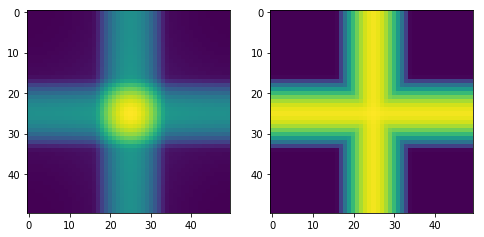

8.41448047709


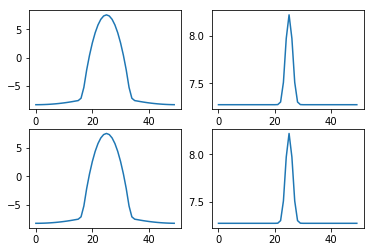

In [136]:
numberOfSamplings = U.shape[0]
numberOfBasis = size

l = SIGMA
init_alpha = I*l*np.sqrt(2*PI)
init_Cx = Cx
init_Cy = Cy
init_U = U.astype(int)

PHI_Re, PHI_Im = Vobs_function(init_U,l,init_alpha,init_Cx,init_Cy, Tu = 0.03, Tv = 0.03, IMAGE_SIZE_X = 50, IMAGE_SIZE_Y = 50)

def matrix_points(U,V_real, V_imag, IMAGE_SIZE_X = 50, IMAGE_SIZE_Y = 50):
    U = U.astype(int)
    out_real = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    out_imag = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    for i in range(U.shape[0]):
        out_real[U[i,0],U[i,1]] = V_real[i]
        out_imag[U[i,0],U[i,1]] = V_imag[i]
        
    return out_real, out_imag


Im_pix_real, Im_pix_imag = matrix_points(U,V[:,0], V[:,1])
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(8)
Im_pix = np.log(np.sqrt(Im_pix_real*Im_pix_real+Im_pix_imag*Im_pix_imag) +1e-12)
ax[0].imshow( Im_pix )
print(np.max(Im_pix))

Im_ind_real, Im_ind_imag = matrix_points(U,PHI_Re.eval(), PHI_Im.eval())
Im_ind = np.log(np.sqrt(Im_ind_real*Im_ind_real+Im_ind_imag*Im_ind_imag) +1e-12)
ax[1].imshow( Im_ind )
plt.show(fig)
print(np.max(Im_ind))

fig, ax = plt.subplots(2,2)
ax[0,0].plot(Im_pix[24,:])
ax[0,1].plot(Im_ind[24,:])
ax[1,0].plot(Im_pix[:,24])
ax[1,1].plot(Im_ind[:,24])
plt.show()

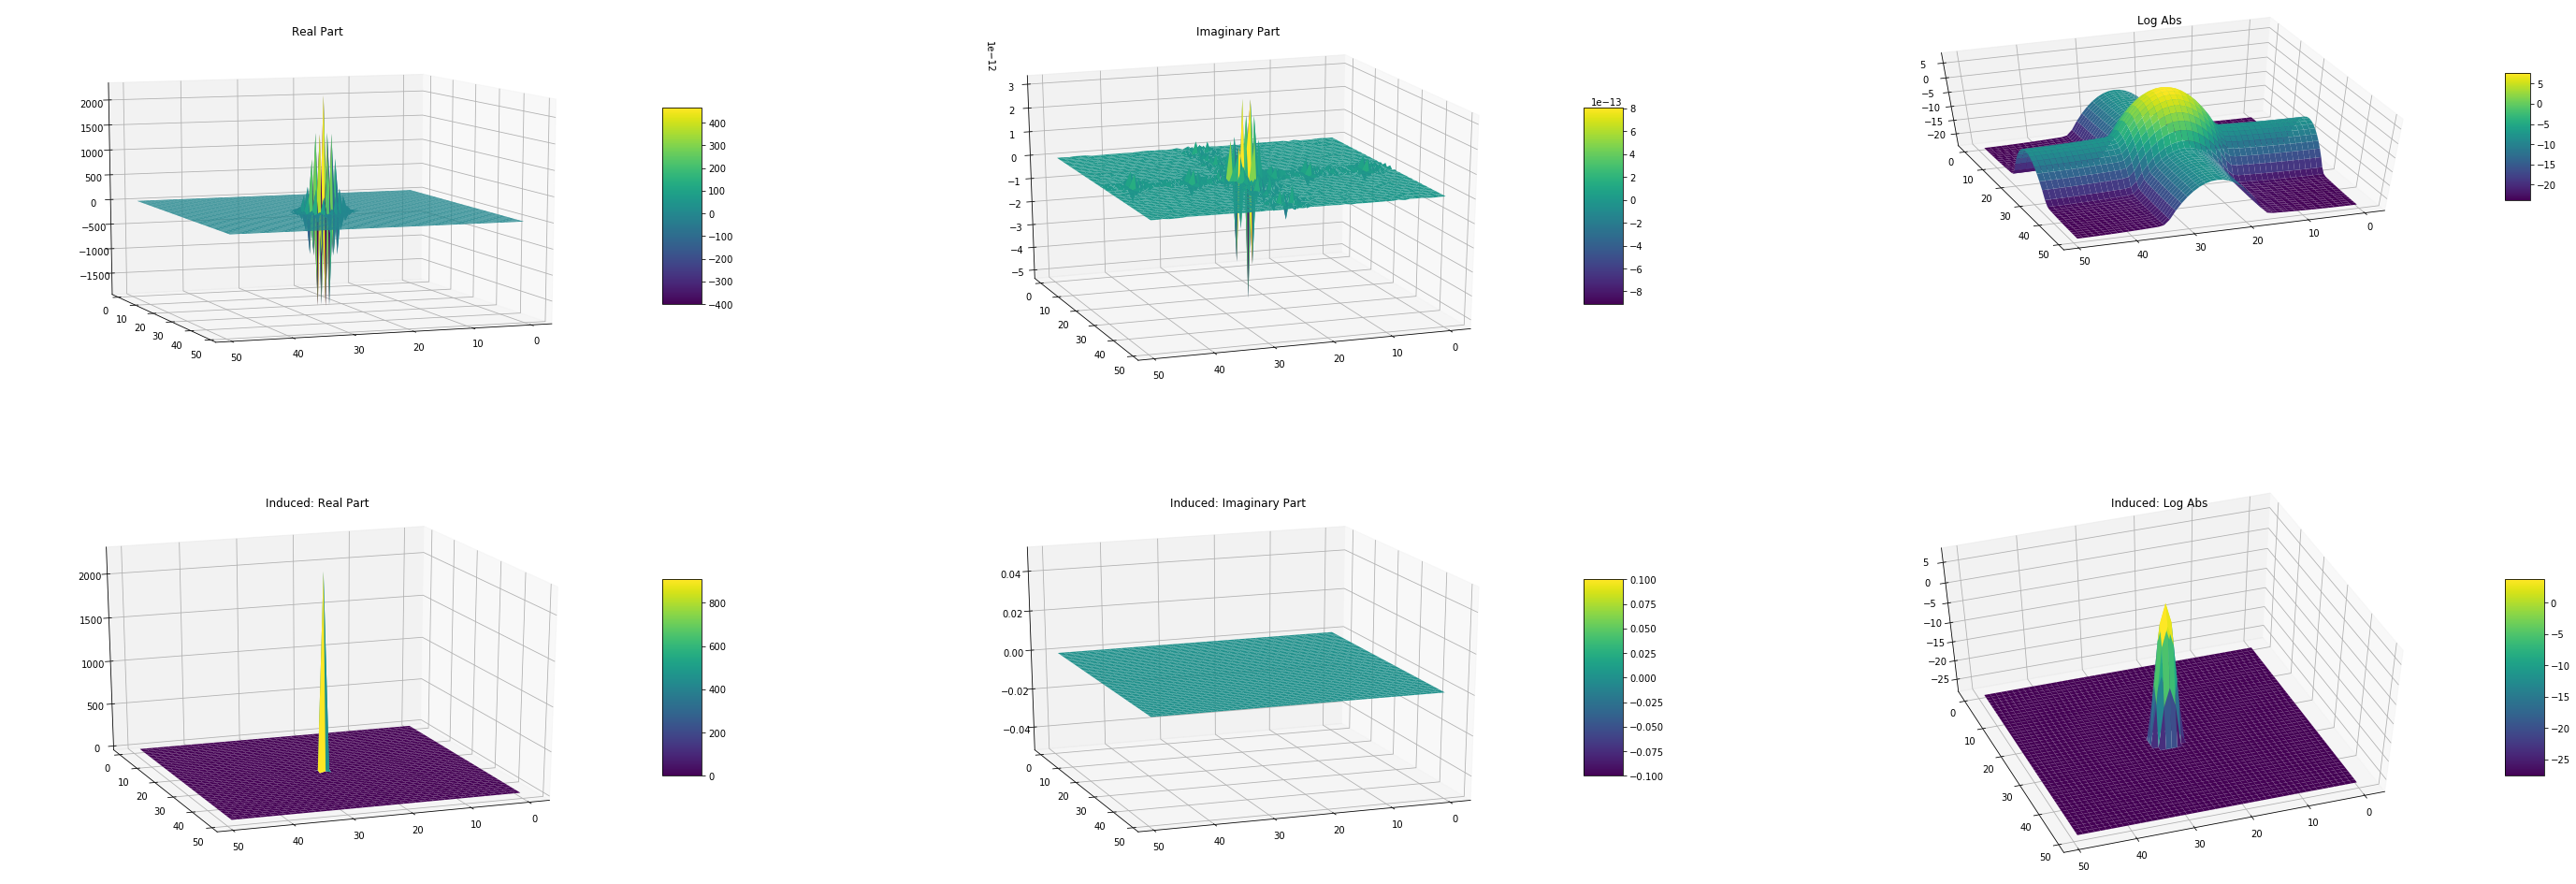

In [109]:
# 3D plotting
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(2, 3, 1, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = Im_pix_real


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Real Part")

ax.view_init(elev=10., azim = 70)

# 3D plotting
ax = fig.add_subplot(2, 3, 2, projection='3d')


UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = Im_pix_imag


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Imaginary Part")

ax.view_init(elev=20., azim = 70)

# 3D plotting
ax = fig.add_subplot(3, 3, 3, projection='3d')

UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = Im_pix


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Log Abs")

ax.view_init(elev=50., azim = 70)

ax = fig.add_subplot(2, 3, 4, projection='3d')

UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = Im_ind_real


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Induced: Real Part")

ax.view_init(elev=20., azim = 70)



ax = fig.add_subplot(2, 3, 5, projection='3d')

UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = Im_ind_imag


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Induced: Imaginary Part")

ax.view_init(elev=20., azim = 70)


ax = fig.add_subplot(2, 3, 6, projection='3d')

UU = np.arange(0,IMAGE_SIZE_X,1)
VV = np.arange(0,IMAGE_SIZE_Y,1)
UU, VV = np.meshgrid(UU, VV)
WW = Im_ind


## Plot the surface.
surf = ax.plot_surface(UU, VV, WW, cmap=cm.viridis)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Induced: Log Abs")

ax.view_init(elev=50., azim = 70)

fig.set_figheight(17)
fig.set_figwidth(50)

plt.savefig('img_sinthc_fourier.png', format='png')
plt.show(fig)

In [ ]:
#from scipy import optimize

numberOfSamplings = U.shape[0]
numberOfBasis = size
rbf_model = pm.Model()

l = SIGMA
init_alpha = I*l*np.sqrt(2*PI)
init_Cx = Cx
init_Cy = Cy
init_sigma = 10*np.array([[1,1],[1,2]])

print('Initial Conditions:')
print('Number of Basis: %s; Number of Samplings: %s' % (numberOfBasis, numberOfSamplings))
print('Cx,Cy: %s,%s; ' % (init_Cx,init_Cy)),
print('alpha: %s; ' % (init_alpha)),
print('l: %s' % l)
with rbf_model:
    alpha_model = pm.Normal('alpha', mu=init_alpha, sd=200, shape = [1, numberOfBasis])
    Cx_model = pm.Normal('Cx', mu=init_Cx, sd=20, shape = [1, numberOfBasis])
    Cy_model = pm.Normal('Cy', mu=init_Cy, sd=20, shape = [1, numberOfBasis])
    l_model = pm.Lognormal('l', mu = l, sd=20, shape = 1)
    sigma_model = pm.Lognormal('sigma', init_sigma, np.ones(2), shape=(2,2), testval=init_sigma)

    PHI_Re, PHI_Im = Vobs_function(U, l_model, alpha_model, Cx_model, Cy_model)
    V_model = tt.stack([PHI_Re, PHI_Im], axis = 1)
    
    V_obs = pm.MvNormal('V_obs', mu=V_model, cov=sigma_model, observed=V)
    
    n_samples = 5000
    
    step = pm.NUTS()
    trace = pm.sample(n_samples, step)
#    estimation = find_MAP(model = rbf_model)
#    print(estimation)

In [ ]:
ax = pm.traceplot(trace, figsize=(20,20))

for i in range(5):
    for j in range(2):
        axe = ax[i,j]
        for item in ([axe.title, axe.xaxis.label, axe.yaxis.label] +
                     axe.get_xticklabels() + axe.get_yticklabels()):
            item.set_fontsize(26)plt.savefig('trace.png', format='png')

plt.tight_layout()
plt.savefig('trace.png', format='png')
plt.show()

In [ ]:
print( 100*((init_alpha - estimation['alpha'])/init_alpha)[0] )
print( 100*((Cx - estimation['Cx'])/Cx)[0] )
print( 100*((Cy - estimation['Cy'])/Cy)[0] )
print( "%s %s" % (l,estimation['l_log_'][0]))